In [ ]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
from datasets import load_dataset
%load_ext autoreload
%autoreload 2

In [410]:
# verdict_group_batch = "raljs5b"
# verdict_group_batch = "orz1gnj"
# verdict_group_batch = "5ot6r19"
# verdict_group_batch = "83284bs"
# verdict_group_batch = "7i08qzy"
# verdict_group_batch = "u4efe0h"
# verdict_group_batch = "l93ijir"
# verdict_group_batch = "i0rf9mt"
# verdict_group_batch = "4h2rah9"
# verdict_group_batch = "84bv6lc"
# verdict_group_batch = "irv6rnj"
# verdict_group_batch = "ofxxi38"
# verdict_group_batch = "82f280y"
# verdict_group_batch = "kttenvl"
# verdict_group_batch = "2jujbgv"
# verdict_group_batch = "82ifg57"
# verdict_group_batch = "hpmhxrw"
# verdict_group_batch = "sxn039d"
# verdict_group_batch = "e0mnuii"
# verdict_group_batch = "38wstuq"
# verdict_group_batch = "k1hq1va"
# verdict_group_batch = "yy0xnld"
# verdict_group_batch = "4iznawi"
# verdict_group_batch = "iujqr8f"
# verdict_group_batch = "gzpxjvg"
verdict_group_batch = "sywkbw8"


In [411]:
with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
    data = json.load(f)

verdict_ids = []
for run in data["runs"]:
    verdict_ids.append(run['verdict_run_id'])

In [412]:
data

{'group_run_id': 'sywkbw8',
 'datetime': '2025-12-09T13:03:13.730134',
 'duration_seconds': 1633.8447411060333,
 'runs_per_combination': 1,
 'judge_models': ['google/gemma-3-12b-it',
  'google/gemma-3-27b-it',
  'meta-llama/llama-3-8b-instruct',
  'meta-llama/llama-3.1-8b-instruct',
  'meta-llama/llama-3.1-70b-instruct',
  'meta-llama/llama-3.1-405b-instruct',
  'meta-llama/llama-3.3-70b-instruct',
  'meta-llama/llama-4-scout',
  'meta-llama/llama-4-maverick',
  'openai/gpt-3.5-turbo',
  'openai/gpt-4o-mini',
  'qwen/qwen-2.5-72b-instruct'],
 'debate_run_ids': ['uveal9q',
  'z42o1e7',
  '79t2rwe',
  '2exxeqn',
  'xcmiu00',
  '3ys5csf',
  'pciywxv'],
 'upto_turns': None,
 'runs': [{'model': 'meta-llama/llama-3-8b-instruct',
   'debate_run_id': 'uveal9q',
   'upto_turns': None,
   'run_idx': 0,
   'verdict_run_id': 'iyngcyd'},
  {'model': 'meta-llama/llama-3.1-70b-instruct',
   'debate_run_id': 'uveal9q',
   'upto_turns': None,
   'run_idx': 0,
   'verdict_run_id': '7fgc3bl'},
  {'model'

In [413]:
all_df = prepare_df(specific_verdict_ids=verdict_ids)

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [414]:
verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids)]
verdicts_df.shape

(14722, 90)

In [415]:
verdicts_df[['verdict_run_id_verdicts', 'config_debate_run_id_verdicts', 'config_judge_model_verdicts']].value_counts()

verdict_run_id_verdicts  config_debate_run_id_verdicts  config_judge_model_verdicts       
z1l5hvt                  xcmiu00                        meta-llama/llama-3.1-405b-instruct    198
mci2to2                  xcmiu00                        meta-llama/llama-3.1-70b-instruct     198
n8klv28                  xcmiu00                        meta-llama/llama-4-maverick           198
u6u07ql                  uveal9q                        meta-llama/llama-3.1-405b-instruct    198
3qgeq50                  xcmiu00                        google/gemma-3-12b-it                 198
                                                                                             ... 
owwtmsa                  3ys5csf                        meta-llama/llama-3.1-70b-instruct      87
viweg6b                  3ys5csf                        meta-llama/llama-3-8b-instruct         86
gc7dlig                  3ys5csf                        openai/gpt-4o-mini                     86
7965r5n                  3y

In [416]:
# Showing that repetitions actually have consideralbe variability - 90% in this case - even though average verdict performance come out similar (flipping)

# set1 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == 'zv74feq']
# set2 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == '4j31cg4']

# merge = set1[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']].merge(set2[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']], on=['question_idx_debates'])

# (merge['is_correct_verdict_x'] == merge['is_correct_verdict_y']).sum() / merge.shape[0]


In [417]:
# temp_df = verdicts_df
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

aggregate_acc = aggregate_by_fields(temp_df, fields=['config_model_name_qa_judge'])
aggregate_acc

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name
0,0.643032,0.576202,0.741646,789,707,910,1227,1227,1227,1227,0.417278,2.475610,0.066830,0.165444,google/gemma-3-12b-it
1,0.644082,0.611429,0.768163,789,749,941,1225,1225,1225,1225,0.434286,4.800000,0.032653,0.156735,google/gemma-3-27b-it
2,0.641880,0.530769,0.734188,751,621,859,1170,1170,1170,1170,0.500855,1.830769,0.111111,0.203419,meta-llama/llama-3-8b-instruct
3,0.644317,0.671300,0.843009,788,821,1031,1223,1223,1223,1223,0.503679,-6.363636,-0.026983,0.171709,meta-llama/llama-3.1-405b-instruct
4,0.643500,0.656582,0.830744,787,803,1016,1223,1223,1223,1223,0.471791,-13.312500,-0.013083,0.174162,meta-llama/llama-3.1-70b-instruct
5,0.635481,0.569285,0.725508,720,645,822,1133,1133,1133,1133,0.522507,2.360000,0.066196,0.156222,meta-llama/llama-3.1-8b-instruct
6,0.642975,0.677686,0.831405,778,820,1006,1210,1210,1210,1210,0.485950,-4.428571,-0.034711,0.153719,meta-llama/llama-3.3-70b-instruct
7,0.641688,0.773471,0.867356,745,898,1007,1161,1161,1161,1161,0.453919,-0.712418,-0.131783,0.093885,meta-llama/llama-4-maverick
8,0.642553,0.681702,0.832340,755,801,978,1175,1175,1175,1175,0.525957,-3.847826,-0.039149,0.150638,meta-llama/llama-4-scout
9,0.642739,0.510726,0.764851,779,619,927,1212,1212,1212,1212,0.588284,1.925000,0.132013,0.254125,openai/gpt-3.5-turbo


In [418]:
aggregate_acc['gain'].sort_values(ascending=False)

9     0.254125
2     0.203419
10    0.186985
4     0.174162
3     0.171709
0     0.165444
1     0.156735
5     0.156222
6     0.153719
8     0.150638
11    0.114848
7     0.093885
Name: gain, dtype: float64

(12, 15)


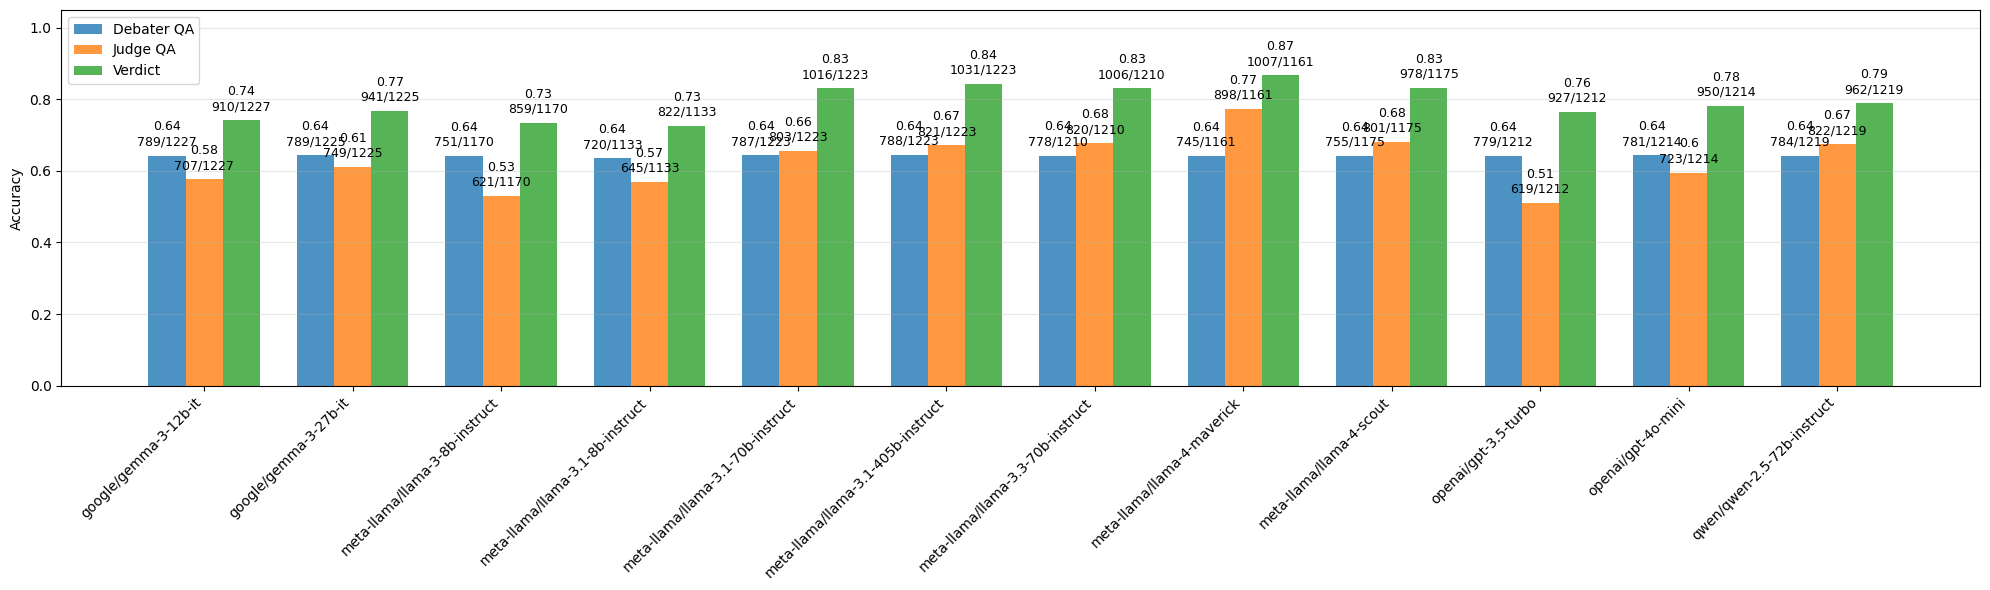

In [419]:
from plot_utils import *
aggregate_acc = aggregate_acc[aggregate_acc['name'] != 'x-ai/grok-4-fast']
print(aggregate_acc.shape)
plot_results_by_name(aggregate_acc, plot_gap_and_gain=False)
plt.show()


In [ ]:
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

temp_df = temp_df[temp_df['config_debater_model_debates'] != 'llama-4-scout']

aggregate_acc = aggregate_by_fields(temp_df, fields=['verdict_run_id_verdicts'])
aggregate_acc

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name
0,0.524064,0.684492,0.802139,98,128,150,187,187,187,187,0.577540,-0.733333,-0.160428,0.117647,0ccm2t5
1,0.533333,0.615385,0.738462,104,120,144,195,195,195,195,0.512821,-1.500000,-0.082051,0.123077,0hfcrmj
2,0.770115,0.580460,0.798851,134,101,139,174,174,174,174,0.540230,1.151515,0.189655,0.218391,0idua5p
3,0.635294,0.635294,0.905882,54,54,77,85,85,85,85,0.529412,inf,0.000000,0.270588,0x0zfxr
4,0.681818,0.611111,0.777778,135,121,154,198,198,198,198,0.363636,2.357143,0.070707,0.166667,10oji5s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.661376,0.613757,0.761905,125,116,144,189,189,189,189,0.412698,3.111111,0.047619,0.148148,xipo7f8
80,0.681818,0.601010,0.833333,135,119,165,198,198,198,198,0.439394,2.875000,0.080808,0.232323,y3k1pz3
81,0.767045,0.579545,0.761364,135,102,134,176,176,176,176,0.460227,0.969697,0.187500,0.181818,ybygx6h
82,0.765714,0.674286,0.851429,134,118,149,175,175,175,175,0.554286,1.937500,0.091429,0.177143,yzjuy9y


In [425]:
aggregate_acc['gain'].mean(), aggregate_acc['gain'].median()

(np.float64(0.17363214756386466), np.float64(0.16666666666666663))

In [426]:
aggregate_acc['gain'].sort_values(ascending=False)

19    0.423529
10    0.376471
55    0.294118
53    0.287179
33    0.272727
        ...   
35    0.090395
54    0.087912
20    0.057592
42    0.056995
47    0.038674
Name: gain, Length: 84, dtype: float64

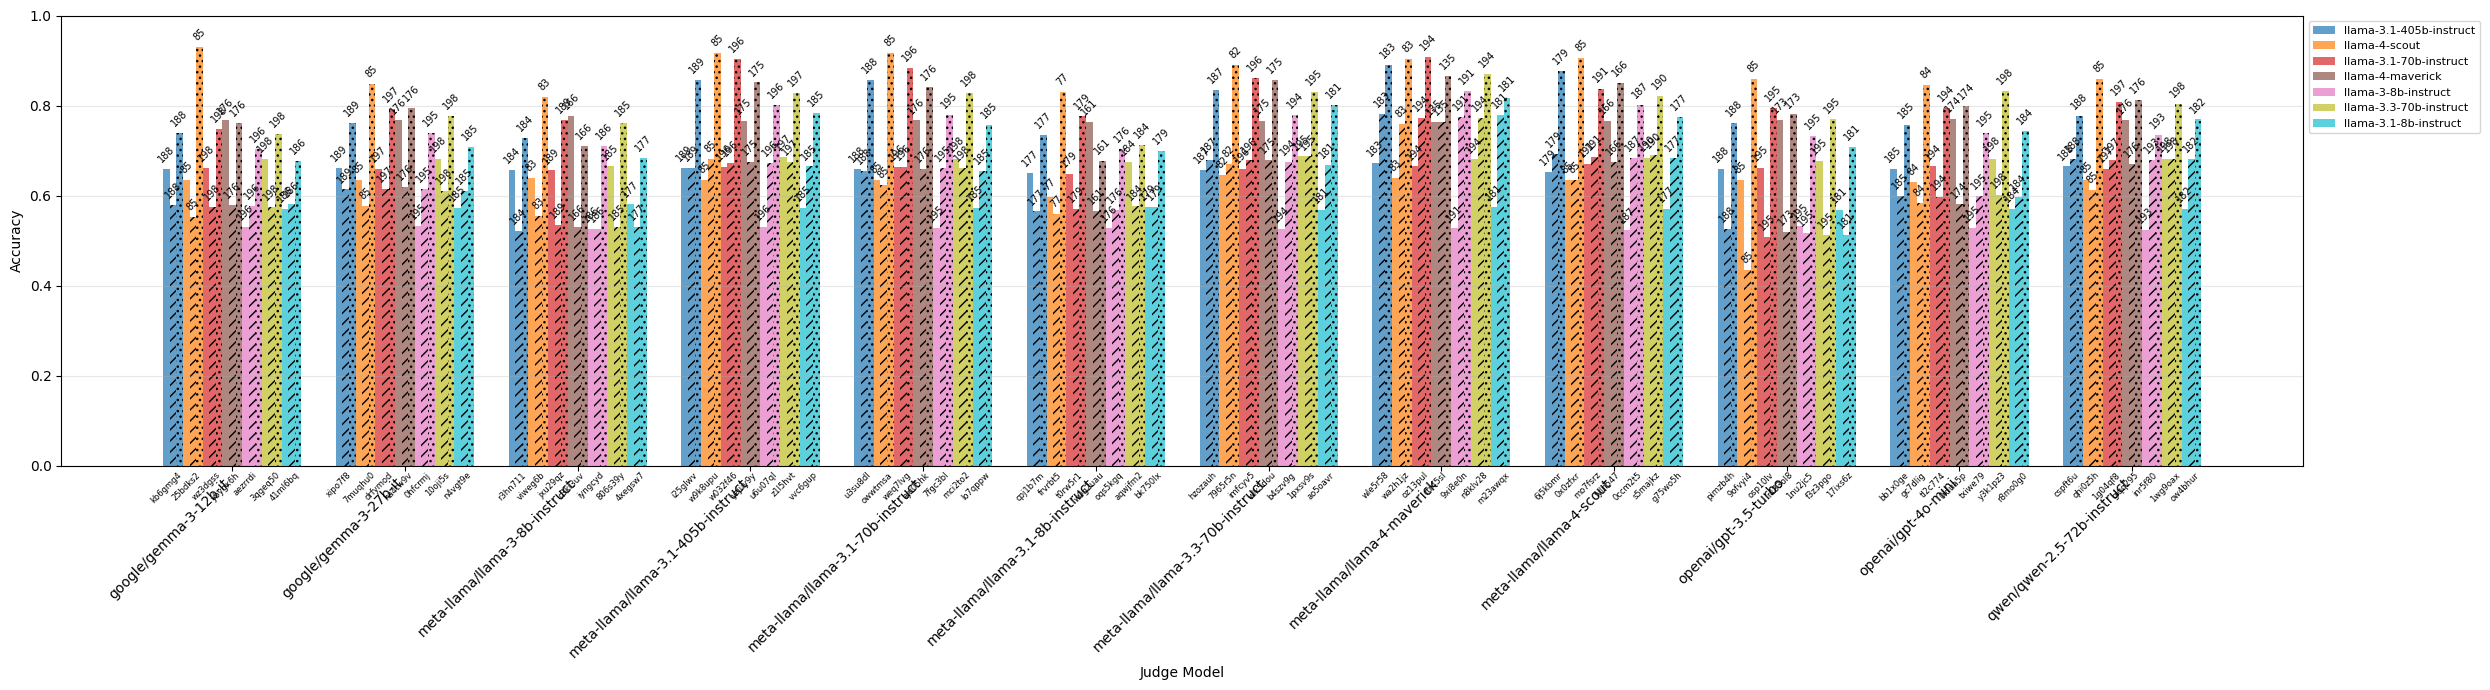

In [427]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

debate_run_id_labels = {
    'uveal9q': 'llama-3-8b-instruct',
    'z42o1e7': 'llama-3.1-8b-instruct',
    '79t2rwe': 'llama-3.1-70b-instruct',
    '2exxeqn': 'llama-3.1-405b-instruct',
    'xcmiu00': 'llama-3.3-70b-instruct',
    '3ys5csf': 'llama-4-scout',
    'pciywxv': 'llama-4-maverick'
}

run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

metrics = ['debater_qa_acc', 'judge_qa_acc', 'verdict_acc']
metric_labels = ['Debater QA', 'Judge QA', 'Verdict']

for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    debate_run_ids = sorted(plot_data['debate_run_id'].unique())
    
    n_judges = len(judge_models)
    n_debates = len(debate_run_ids)
    n_metrics = len(metrics)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (n_debates * n_metrics)
    
    fig, ax = plt.subplots(figsize=(25, 7))
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_debates))
    hatches = ['', '///', '...']
    
    metric_x_y_map = {
        'debater_qa_acc': ('debater_qa_n_correct', 'n_debater_qa_not_null'),
        'judge_qa_acc': ('judge_qa_n_correct', 'n_judge_qa_not_null'),
        'verdict_acc': ('verdict_n_correct', 'n_verdict_not_null')
    }
    
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
            values = []
            verdict_run_ids = []
            x_values = []
            y_values = []
            for judge_model in judge_models:
                row = plot_data[(plot_data['model'] == judge_model) & 
                               (plot_data['debate_run_id'] == debate_run_id)]
                if len(row) > 0:
                    values.append(row[metric].values[0])
                    verdict_run_ids.append(row['verdict_run_id'].values[0])
                    x_field, y_field = metric_x_y_map[metric]
                    x_values.append(int(row[x_field].values[0]))
                    y_values.append(int(row[y_field].values[0]))
                else:
                    values.append(0)
                    verdict_run_ids.append('')
                    x_values.append(0)
                    y_values.append(0)
            
            offset = (i - n_debates / 2 + 0.5) * (group_width / n_debates) + (j - n_metrics / 2 + 0.5) * width
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)}" if j == 0 else ""
            bars = ax.bar(x + offset, values, width, label=label, color=colors[i], alpha=0.7, hatch=hatches[j])
            
            for k, (bar, verdict_run_id, x_val, y_val) in enumerate(zip(bars, verdict_run_ids, x_values, y_values)):
                if verdict_run_id and j == 0:
                    ax.text(bar.get_x() + bar.get_width() / 2, -0.01, verdict_run_id,
                           ha='center', va='top', fontsize=6, rotation=45)
                if x_val > 0 or y_val > 0:
                    pct = int(x_val / y_val * 100) if y_val > 0 else 0
                    label_text = f"{y_val}"
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, label_text,
                           ha='center', va='bottom', fontsize=7, color='black', rotation=45)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    
    from matplotlib.patches import Patch
    legend_elements = []
    for i, debate_run_id in enumerate(debate_run_ids):
        label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)}"
        legend_elements.append(Patch(facecolor=colors[i], alpha=0.7, label=label))
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    
    plt.tight_layout()
    
    plt.show()


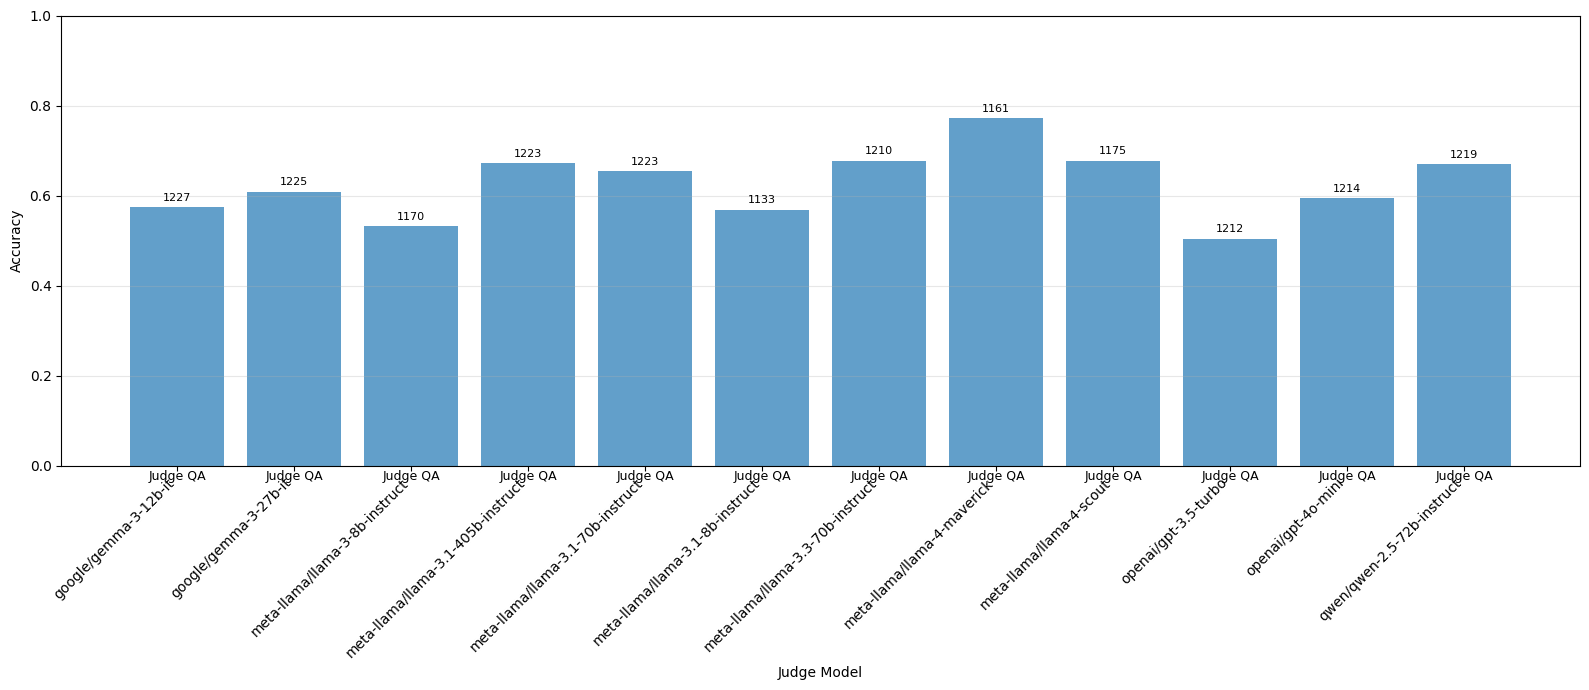

In [378]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list= sorted([x for x in plot_data['upto_turns'].dropna().unique()])
    else:
        upto_turns_list = [None]
    
    n_judges = len(judge_models)
    n_turns = len(upto_turns_list)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (1 + n_turns)
    
    bar_color = plt.cm.tab10(0)
    chose_idx_0_color = plt.cm.tab10(1)
    hatches = ['', '///']
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    judge_qa_values = []
    judge_qa_counts = []
    for judge_model in judge_models:
        rows = plot_data[plot_data['model'] == judge_model]
        if len(rows) > 0:
            avg_value = rows['judge_qa_acc'].mean()
            judge_qa_values.append(avg_value)
            n_correct = int(rows['judge_qa_n_correct'].sum())
            n_total = int(rows['n_judge_qa_not_null'].sum())
            judge_qa_counts.append((n_correct, n_total))
        else:
            judge_qa_values.append(0)
            judge_qa_counts.append((0, 0))
    
    judge_qa_offset = -group_width / 2 + width / 2
    bars_judge_qa = ax.bar(x + judge_qa_offset, judge_qa_values, width, label='Judge QA', color=bar_color, alpha=0.7, hatch=hatches[0])
    
    for bar, value, (n_correct, n_total) in zip(bars_judge_qa, judge_qa_values, judge_qa_counts):
        ax.text(bar.get_x() + bar.get_width() / 2, -0.01, 'Judge QA',
               ha='center', va='top', fontsize=9)
        if n_total > 0:
            pct = int(value * 100)
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{n_total}',
                   ha='center', va='bottom', fontsize=8)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        verdict_values = []
        chose_idx_0_values = []
        verdict_counts = []
        for judge_model in judge_models:
            rows = turn_data[turn_data['model'] == judge_model]
            if len(rows) > 1:
                raise Exception('Check why rows greater than 1')
            verdict_values.append(rows.iloc[0]['verdict_acc'])
            chose_idx_0_values.append(rows.iloc[0]['verdict_chose_idx_0'])
            n_correct = int(rows.iloc[0]['verdict_n_correct'])
            n_total = int(rows.iloc[0]['n_verdict_not_null'])
            verdict_counts.append((n_correct, n_total))

        
        offset = judge_qa_offset + width + i * width
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bars = ax.bar(x + offset, verdict_values, width, label=label, color=bar_color, alpha=0.7, hatch=hatches[1])
        
        for k, (bar, value, (n_correct, n_total)) in enumerate(zip(bars, verdict_values, verdict_counts)):
            turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
            ax.text(bar.get_x() + bar.get_width() / 2, -0.01, turn_label,
                   ha='center', va='top', fontsize=12)
            if n_total > 0:
                pct = int(value * 100)
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{n_total}',
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


### By Category

In [395]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)
dataset_df['high_level_domain'] = dataset_df['high_level_domain'].str.lower()
verdicts_df = verdicts_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))

In [ ]:
# mmlu_dataset = load_dataset('TIGER-Lab/MMLU-Pro')['test']

# category_map = {}
# for idx in range(len(mmlu_dataset)):
#     category_map[idx] = mmlu_dataset[idx].get('category', None)
# verdicts_df['high_level_domain'] = verdicts_df['question_idx_debates'].map(category_map)

In [396]:
# temp_df = verdicts_df.copy()

# chemistry_df = temp_df[temp_df['high_level_domain'] == 'chemistry']
# physics_df = temp_df[temp_df['high_level_domain'] == 'physics']

# chemistry_acc = aggregate_by_fields(chemistry_df, ['config_judge_model_verdicts'])
# physics_acc = aggregate_by_fields(physics_df, ['config_judge_model_verdicts'])

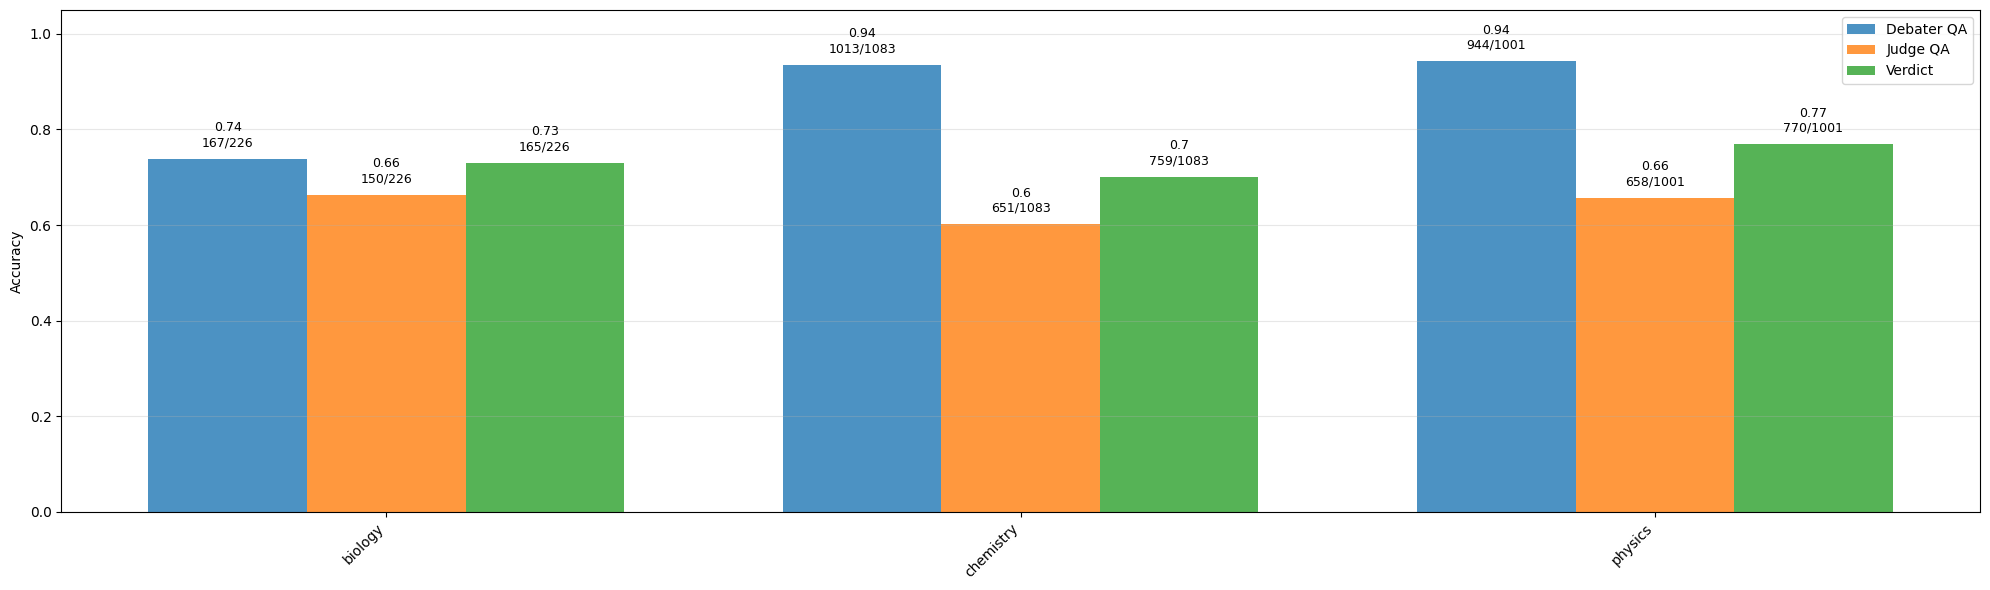

In [398]:
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

aggregate_acc = aggregate_by_fields(temp_df, fields=['high_level_domain'])
aggregate_acc

from plot_utils import *
plot_results_by_name(aggregate_acc, field=None, plot_gap_and_gain=False)
plt.show()

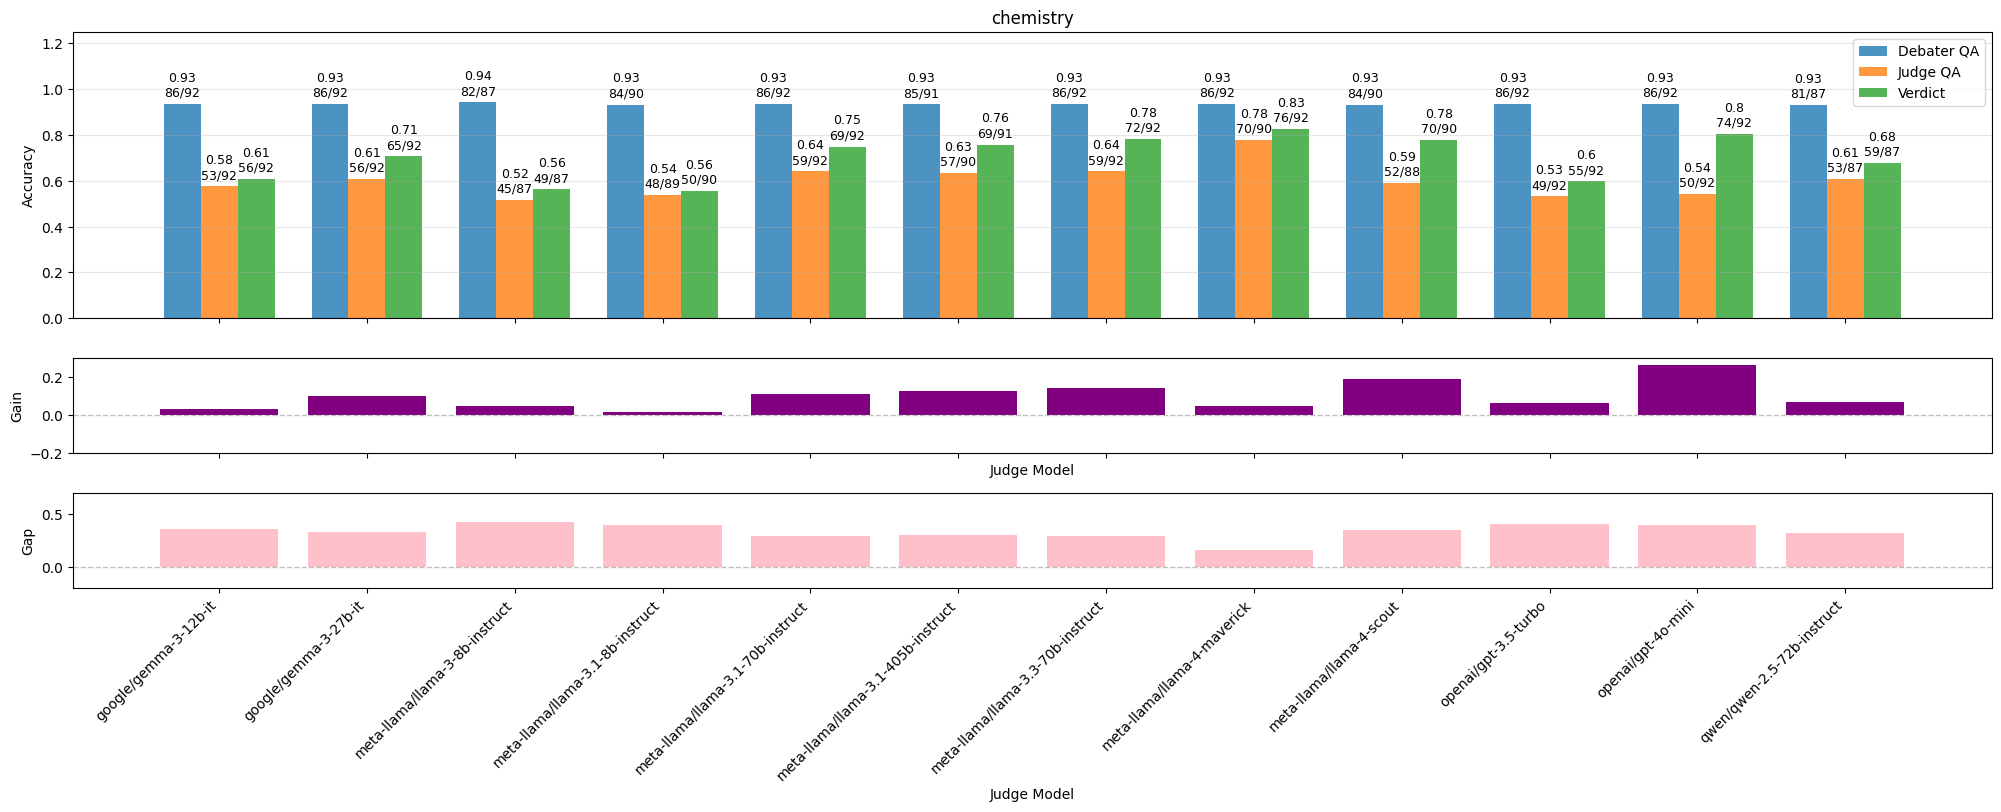

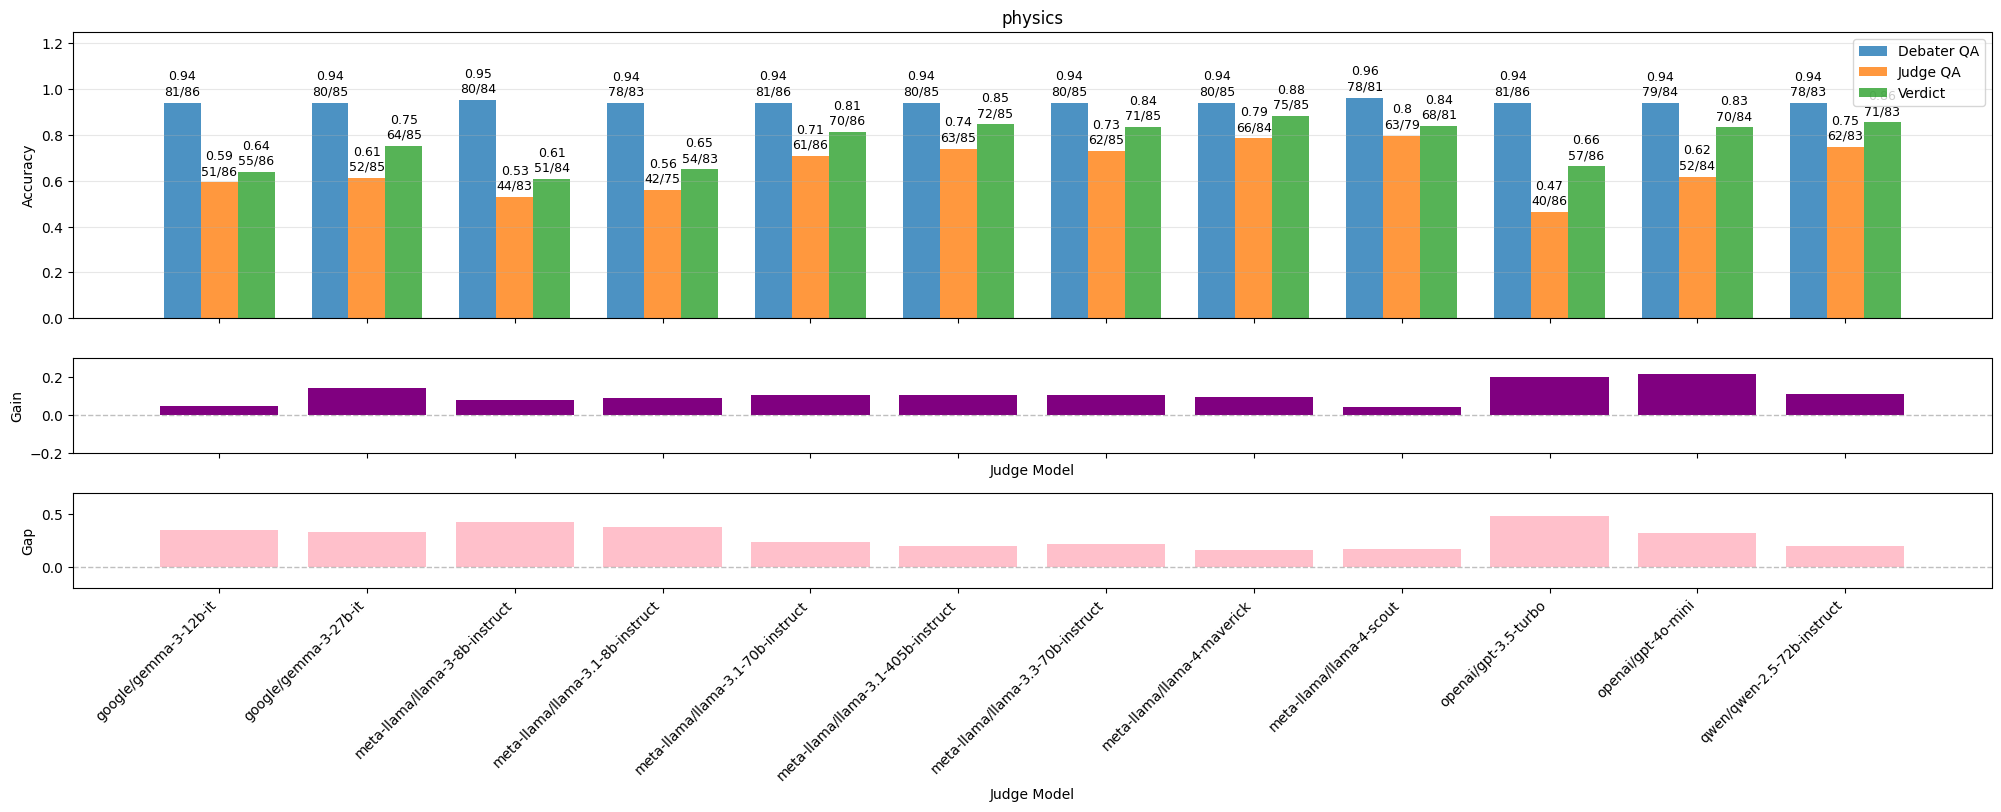

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: invalid value encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


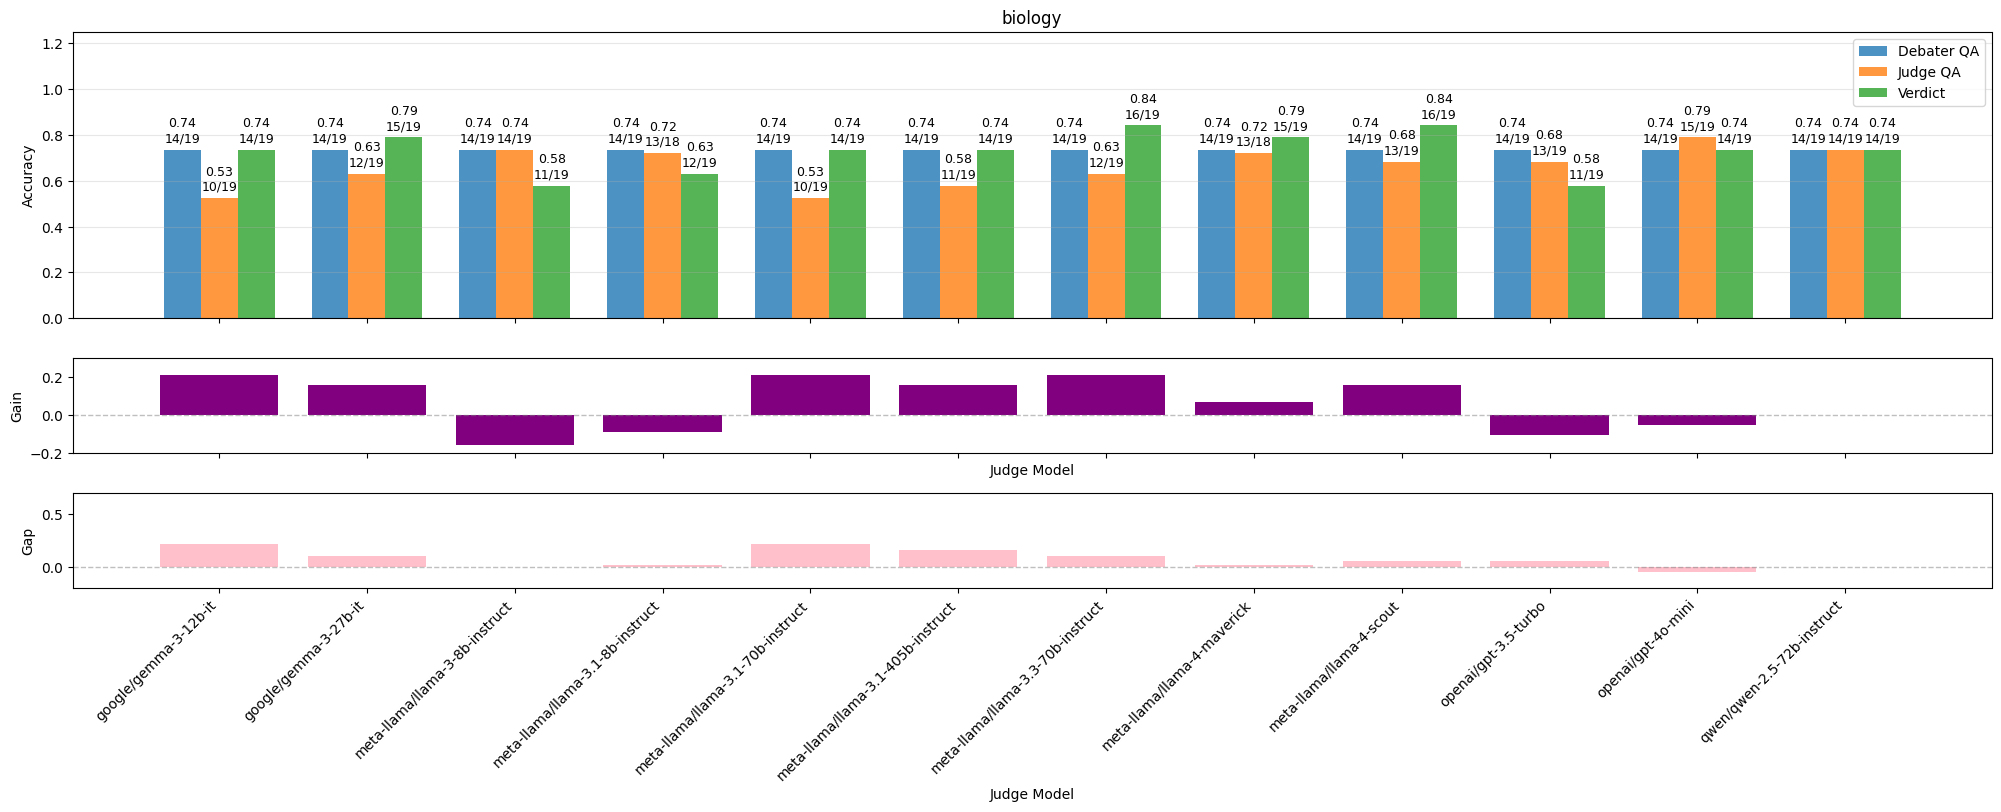

In [400]:
for field in verdicts_df['high_level_domain'].unique():
    field_df = verdicts_df[verdicts_df['high_level_domain'] == field]
    field_acc = aggregate_by_fields(field_df, ['config_judge_model_verdicts'])

    ax_acc, ax_gain, ax_gap = plot_results_by_name(field_acc)
    ax_acc.set_title(f'{field}')

    ax_gain.set_ylim([-.2, .3])
    ax_gap.set_ylim([-.2, .7])
    plt.show()

meta-llama/llama-3-8b-instruct


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


AttributeError: 'Axes' object has no attribute 'show'

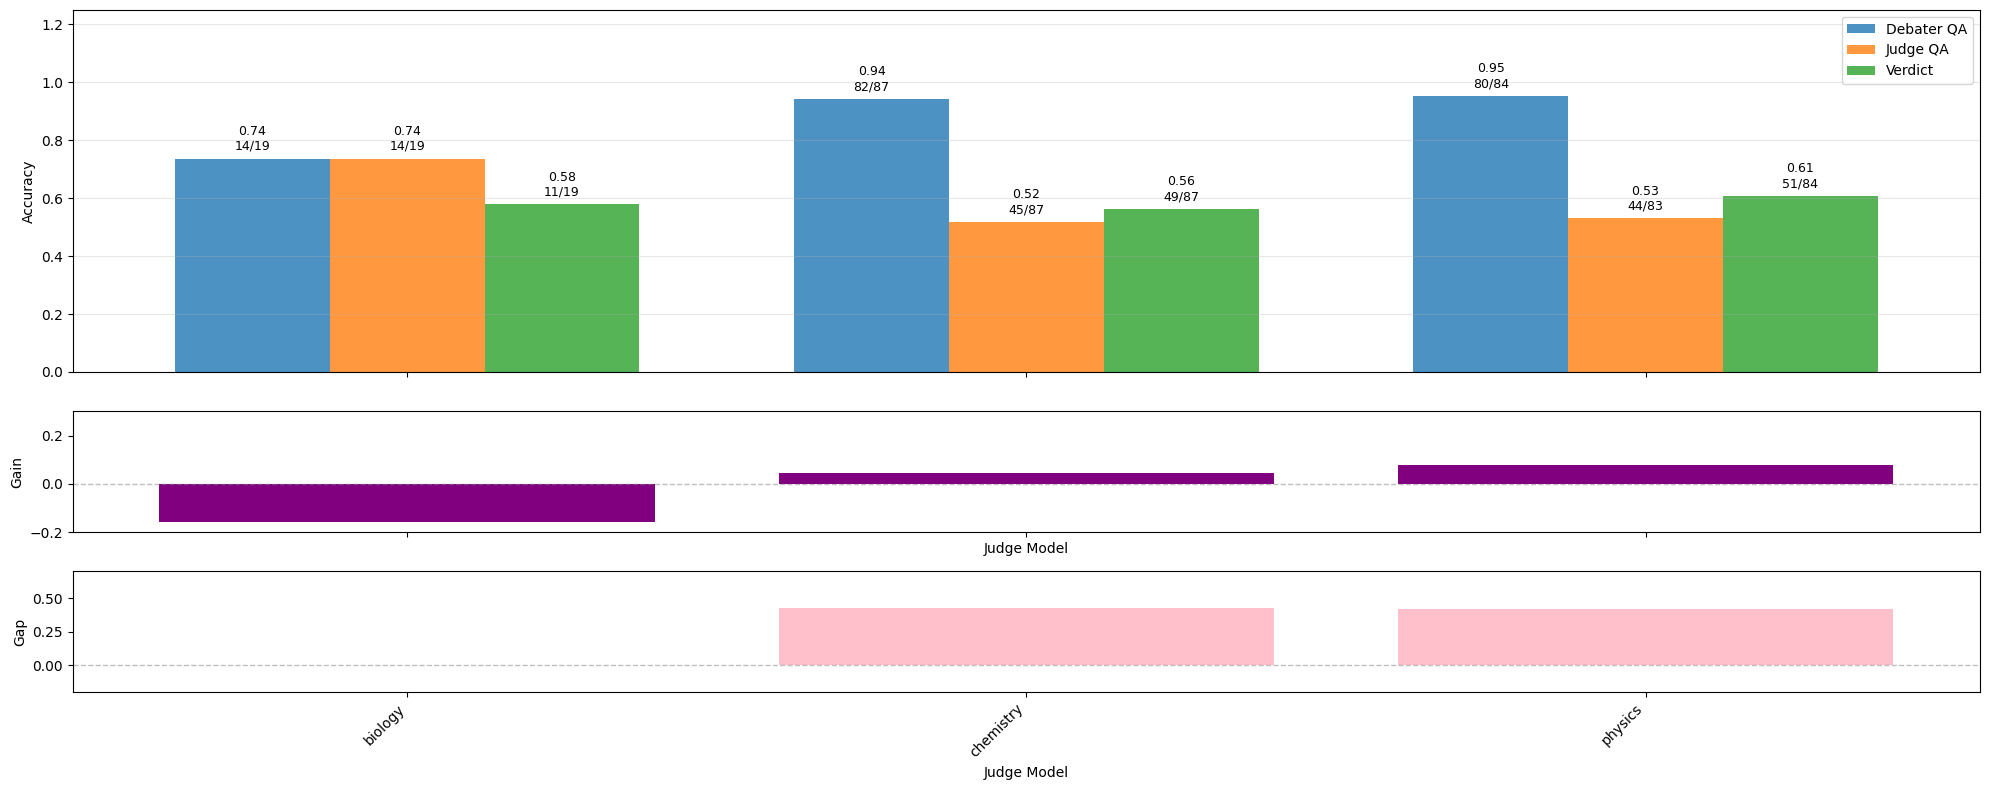

In [401]:
for model_name in verdicts_df['config_judge_model_verdicts'].unique():
    print(model_name)
    model_df = verdicts_df[verdicts_df['config_judge_model_verdicts'] == model_name]
    model_acc = aggregate_by_fields(model_df, ['high_level_domain'])

    plt, ax_gain, ax_gap = plot_results_by_name(model_acc, field=None)

    ax_gain.set_ylim([-.2, .3])
    ax_gap.set_ylim([-.2, .7])
    plt.show()

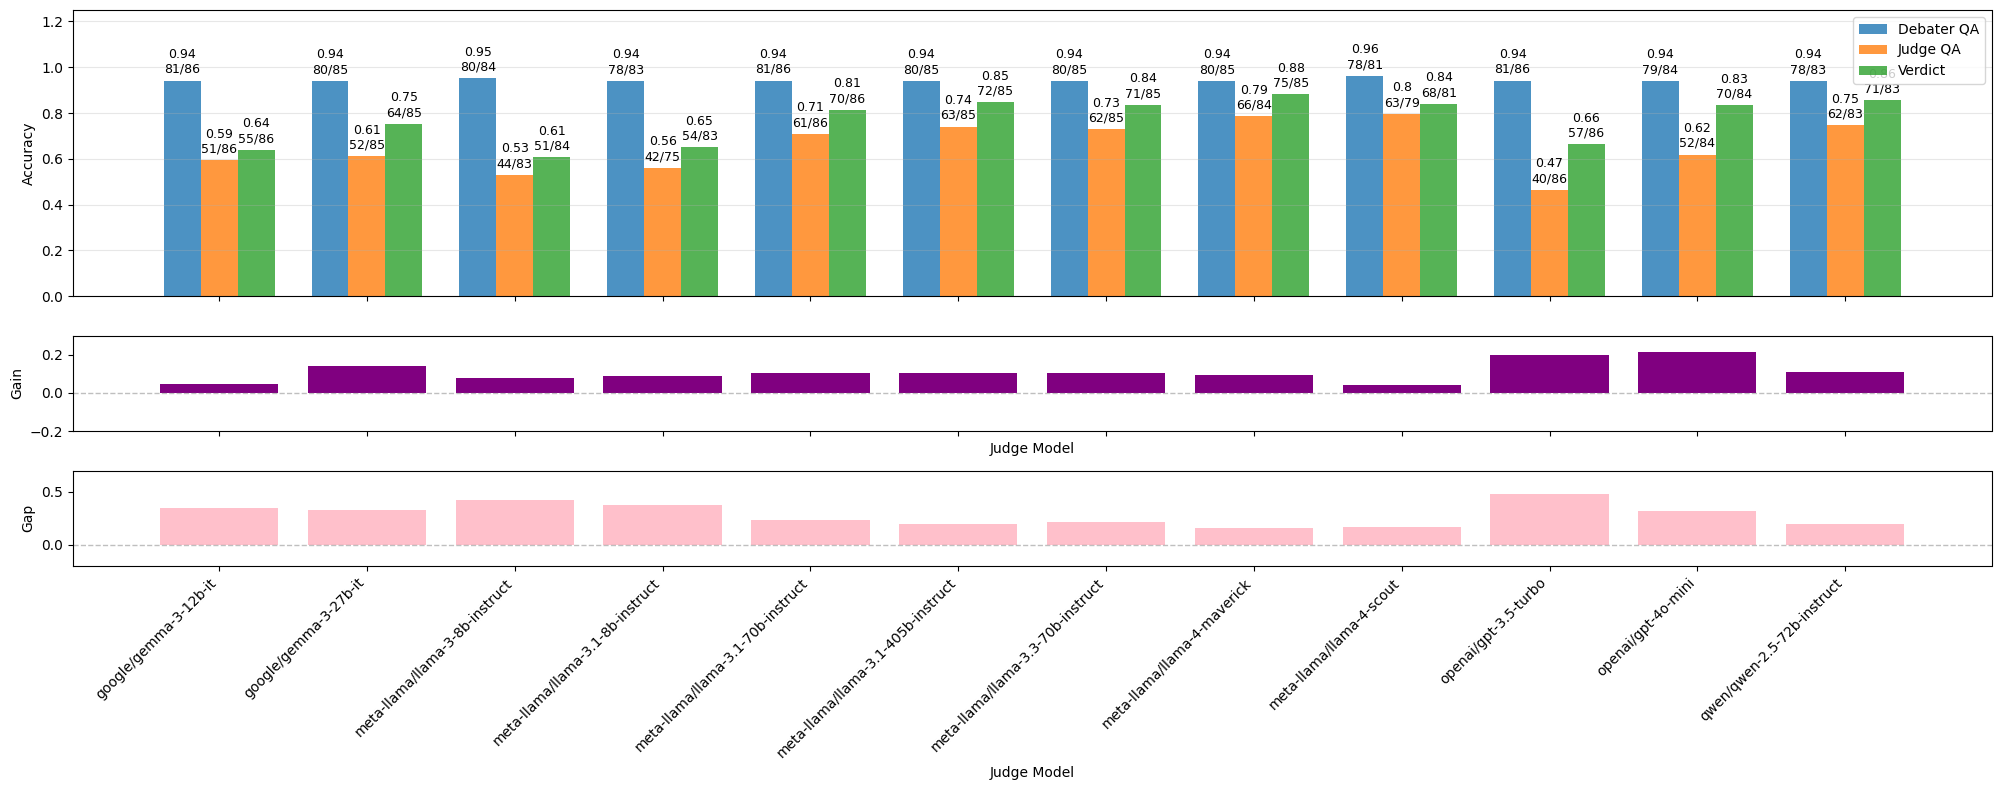

In [190]:
plt, ax_gain, ax_gap = plot_results_by_name(physics_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

In [193]:
physics_acc['gain'].mean(), chemistry_acc['gain'].mean()
# physics_acc['gain'].median(), chemistry_acc['gain'].median()



(np.float64(0.1108999244769499), np.float64(0.09981502260383888))

### By Difficulty

In [ ]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)
dataset_df['high_level_domain'] = dataset_df['high_level_domain'].str.lower()
verdicts_df = verdicts_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))

In [404]:
dataset_df[["Writer's Difficulty Estimate", 'Question Difficulty_EV_1', 'Question Difficulty_EV_2']]

,Writer's Difficulty Estimate,Question Difficulty_EV_1,Question Difficulty_EV_2
0,Hard undergraduate level (could be a question ...,Easy undergraduate level (or easier),Hard undergraduate level (could be a question ...
1,Hard graduate level (could be a question on a ...,Hard undergraduate level (could be a question ...,Hard graduate level (could be a question on a ...
2,Hard undergraduate level (could be a question ...,Easy undergraduate level (or easier),Hard undergraduate level (could be a question ...
3,Hard undergraduate level (could be a question ...,Easy undergraduate level (or easier),Hard undergraduate level (could be a question ...
4,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...
...,...,...,...
193,Post-graduate level or harder (only individual...,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...
194,Hard graduate level (could be a question on a ...,Hard undergraduate level (could be a question ...,Hard graduate level (could be a question on a ...
195,Hard graduate level (could be a question on a ...,Hard graduate level (could be a question on a ...,Hard graduate level (could be a question on a ...
196,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...


In [405]:
dataset_df["Writer's Difficulty Estimate"].value_counts()

Writer's Difficulty Estimate
Hard undergraduate level (could be a question on a hard undergraduate exam for students majoring in the subject)               118
Hard graduate level (could be a question on a hard graduate exam for PhD students in the domain)                                61
Post-graduate level or harder (only individuals with years of highly specialized expertise could reliably answer correctly)     12
Easy undergraduate level (or easier)                                                                                             3
Name: count, dtype: int64

In [409]:
dataset_df['Question Difficulty_EV_1'].value_counts()

Question Difficulty_EV_1
Hard undergraduate level (could be a question on a hard undergraduate exam for students majoring in the subject)               101
Hard graduate level (could be a question on a hard graduate exam for PhD students in the domain)                                43
Easy undergraduate level (or easier)                                                                                            40
Post-graduate level or harder (only individuals with years of highly specialized expertise could reliably answer correctly)      9
Name: count, dtype: int64

In [408]:
dataset_df['Question Difficulty_EV_2'].value_counts()

Question Difficulty_EV_2
Hard undergraduate level (could be a question on a hard undergraduate exam for students majoring in the subject)               105
Hard graduate level (could be a question on a hard graduate exam for PhD students in the domain)                                57
Easy undergraduate level (or easier)                                                                                            27
Post-graduate level or harder (only individuals with years of highly specialized expertise could reliably answer correctly)      7
Name: count, dtype: int64